In [1]:
import sys
sys.path.insert(0, "../")


import random

import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from src.dataloader import *
from src.models import *
from triage.triage import Triage
from src.utils import *


plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])


_ALL_REGRESSION_DATASETS = ALL_REGRESSION_DATASETS

nest = 20
uci_datasets = [
    "boston",
    "star",
    "bio",
    "concrete",
    "protein",
    "bike",
]

In [2]:
def get_uci(dataset):

    if dataset == "prostate":
        X, y, _ = load_seer_cutract_dataset(name="seer", seed=42)

    if dataset in uci_datasets:
        regression_datasets = list(_ALL_REGRESSION_DATASETS.keys())
        regression_datasets.sort()

        if dataset in regression_datasets:
            # xlrd, openpyxl
            import tempfile

            dataset_name = regression_datasets[mapper[dataset]]
            with tempfile.TemporaryDirectory() as data_dir:
                # download and load data
                download_regression_dataset(dataset_name, data_dir)
                X, y = load_regression_dataset(
                    dataset_name, data_dir, shuffle_train=True, batch_size=512
                )
        else:
            X, y = GetDataset(dataset, "../data/")

    df_overall = pd.DataFrame(X)
    df_overall["y"] = y

    if len(df_overall) > 10000:
        df_overall = df_overall.sample(n=10000)

        X = np.array(df_overall.drop(columns=["y"]))
        y = np.array(df_overall["y"])

    return X, y

In [3]:
def plot(final_results, dataset):
    for model in list(final_results[dataset].keys()):
        metric = final_results[dataset][model]["pvals"]
        mse_score = final_results[dataset][model]["mse"]

        mean = np.mean(metric, axis=-1)
        var = np.std(metric, axis=-1)

        plt.scatter(var, mean, label=f"{model}={mse_score:0.2f}")
        plt.xlabel("V")
        plt.ylabel("C")
        plt.legend()
        #plt.savefig(f"figs/{dataset}_{nest}.pdf")
    
    plt.show()

In [4]:
dataset_lists = ["prostate", "boston", "concrete", "star", "protein", "bio"]

mapper = {}
for i, val in enumerate(regression_datasets):
    mapper[val] = i

n_runs = 1
cal_size = 0.25

seed = 42
final_results = {}
final_corr = {}
for nest in [nest]:
    for dataset in dataset_lists:
        plt.figure()
        try:
            results = {}

            models = [
                CatBoostRegressor(n_estimators=nest + 10, random_state=seed),
                xgb.XGBRegressor(n_estimators=nest, random_state=seed),
            ]
            modelnames = ["cat", "xgb"]

            for idx, learner in enumerate(models):
                prop_discarded = []
                mse = []
                mae = []

                for j in range(n_runs):

                    seed = j * 10
                    random.seed(seed)
                    seed_everything(seed)

                    ###########################################
                    # DATA PROCESSING
                    ###########################################

                    X_prop_train, y_prop_train = get_uci(dataset=dataset)

                    min_y = y_prop_train.min()
                    max_y = y_prop_train.max()

                    y_prop_train = np.array(
                        [
                            (y_prop_train[i] - min_y) / (max_y - min_y)
                            for i in range(len(y_prop_train))
                        ]
                    )

                    try:
                        y_prop_train = pd.Series(y_prop_train)
                    except:
                        y_prop_train = pd.Series(y_prop_train.reshape(-1))

                    X_eval, y_eval = get_uci(dataset=dataset)

                    y_eval = np.array(
                        [
                            (y_eval[i] - min_y) / (max_y - min_y)
                            for i in range(len(y_eval))
                        ]
                    )

                    try:
                        y_eval = pd.Series(y_eval)
                    except:
                        y_eval = pd.Series(y_eval.reshape(-1))

                    test_ids = random.sample(
                        list(range(len(y_eval))), int(0.5 * len(y_eval))
                    )
                    try:
                        X_test = X_eval.iloc[test_ids, :]
                    except:
                        X_test = X_eval[test_ids, :]

                    try:
                        y_test = y_eval.iloc[test_ids]
                    except:
                        y_test = y_eval[test_ids]

                    remaining_eval_ids = np.setdiff1d(
                        range(len(y_eval)), test_ids)

                    try:
                        _, X_cal, _, y_cal = train_test_split(
                            X_eval.iloc[remaining_eval_ids, :],
                            y_eval.iloc[remaining_eval_ids],
                            test_size=cal_size,
                            random_state=seed,
                        )
                    except:
                        _, X_cal, _, y_cal = train_test_split(
                            X_eval[remaining_eval_ids, :],
                            y_eval[remaining_eval_ids],
                            test_size=cal_size,
                            random_state=seed,
                        )

                    X_prop_train, X_cal, X_test = (
                        np.array(X_prop_train),
                        np.array(X_cal),
                        np.array(X_test),
                    )
                    y_prop_train, y_cal, y_test = (
                        np.array(y_prop_train),
                        np.array(y_cal),
                        np.array(y_test),
                    )

                    prop = 0.1
                    num_ids = int(prop * len(y_prop_train))
                    last_ids = range(len(y_prop_train))

                    ###########################################
                    # RUN TRIAGE
                    ###########################################
                    learner.fit(X_prop_train, y_prop_train)
                    y_eval = y_prop_train
                    X_eval = X_prop_train

                    triage = Triage(
                        X_eval=X_eval,
                        y_eval=y_eval,
                        X_cal=X_cal,
                        y_cal=y_cal,
                        nest=nest,
                        learner=learner,
                    )
                    groups_ids, raw_metrics = triage.run()

                    score_metric = raw_metrics["score_metric"]
                    triage_array = score_metric

                    percentile_thresh = 75
                    thresh = 0.33
                    conf_thresh_low = thresh
                    conf_thresh_high = 1 - thresh
                    conf_thresh = 0.5

                    variability = np.std(triage_array, axis=-1)
                    confidence = np.mean(triage_array, axis=-1)

                    oe_ids = np.where(
                        (confidence <= conf_thresh_low)
                        & (variability <= np.percentile(variability, percentile_thresh))
                    )[0]
                    ue_ids = np.where(
                        (confidence >= conf_thresh_high)
                        & (variability <= np.percentile(variability, percentile_thresh))
                    )[0]

                    other_ids = np.concatenate((oe_ids, ue_ids))
                    we_ids = []
                    for id in range(len(confidence)):
                        if id not in other_ids:
                            we_ids.append(id)

                    we_ids = np.array(we_ids)

                    prop_discarded.append(
                        (len(oe_ids) + len(ue_ids)) / len(X_prop_train)
                    )

                    y_pred = learner.predict(X_test)

                    from sklearn.metrics import mean_squared_error, mean_absolute_error

                    mse.append(mean_squared_error(y_pred, y_test))
                    mae.append(mean_absolute_error(y_pred, y_test))

                results[modelnames[idx]] = {
                    "discard": np.mean(prop_discarded),
                    "mae": np.mean(mae),
                    "mse": np.mean(mse),
                    "pvals": triage_array,
                }
        except Exception as e:
            import traceback
            print(traceback.format_exc())
            print(e)

        final_results[dataset] = results

Learning rate set to 0.5
0:	learn: 0.2954603	total: 47.9ms	remaining: 1.39s
1:	learn: 0.2705980	total: 48.8ms	remaining: 683ms
2:	learn: 0.2607964	total: 49.6ms	remaining: 446ms
3:	learn: 0.2574503	total: 50.3ms	remaining: 327ms
4:	learn: 0.2554696	total: 51ms	remaining: 255ms
5:	learn: 0.2545601	total: 51.7ms	remaining: 207ms
6:	learn: 0.2538126	total: 52.4ms	remaining: 172ms
7:	learn: 0.2533097	total: 53.1ms	remaining: 146ms
8:	learn: 0.2531029	total: 53.8ms	remaining: 126ms
9:	learn: 0.2523287	total: 54.6ms	remaining: 109ms
10:	learn: 0.2520421	total: 55.3ms	remaining: 95.6ms
11:	learn: 0.2519654	total: 56.1ms	remaining: 84.1ms
12:	learn: 0.2515249	total: 57ms	remaining: 74.5ms
13:	learn: 0.2510234	total: 57.9ms	remaining: 66.1ms
14:	learn: 0.2505526	total: 58.6ms	remaining: 58.6ms
15:	learn: 0.2503196	total: 59.4ms	remaining: 52ms
16:	learn: 0.2500188	total: 60.2ms	remaining: 46.1ms
17:	learn: 0.2496405	total: 61ms	remaining: 40.7ms
18:	learn: 0.2493124	total: 61.8ms	remaining: 35.

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

prostate


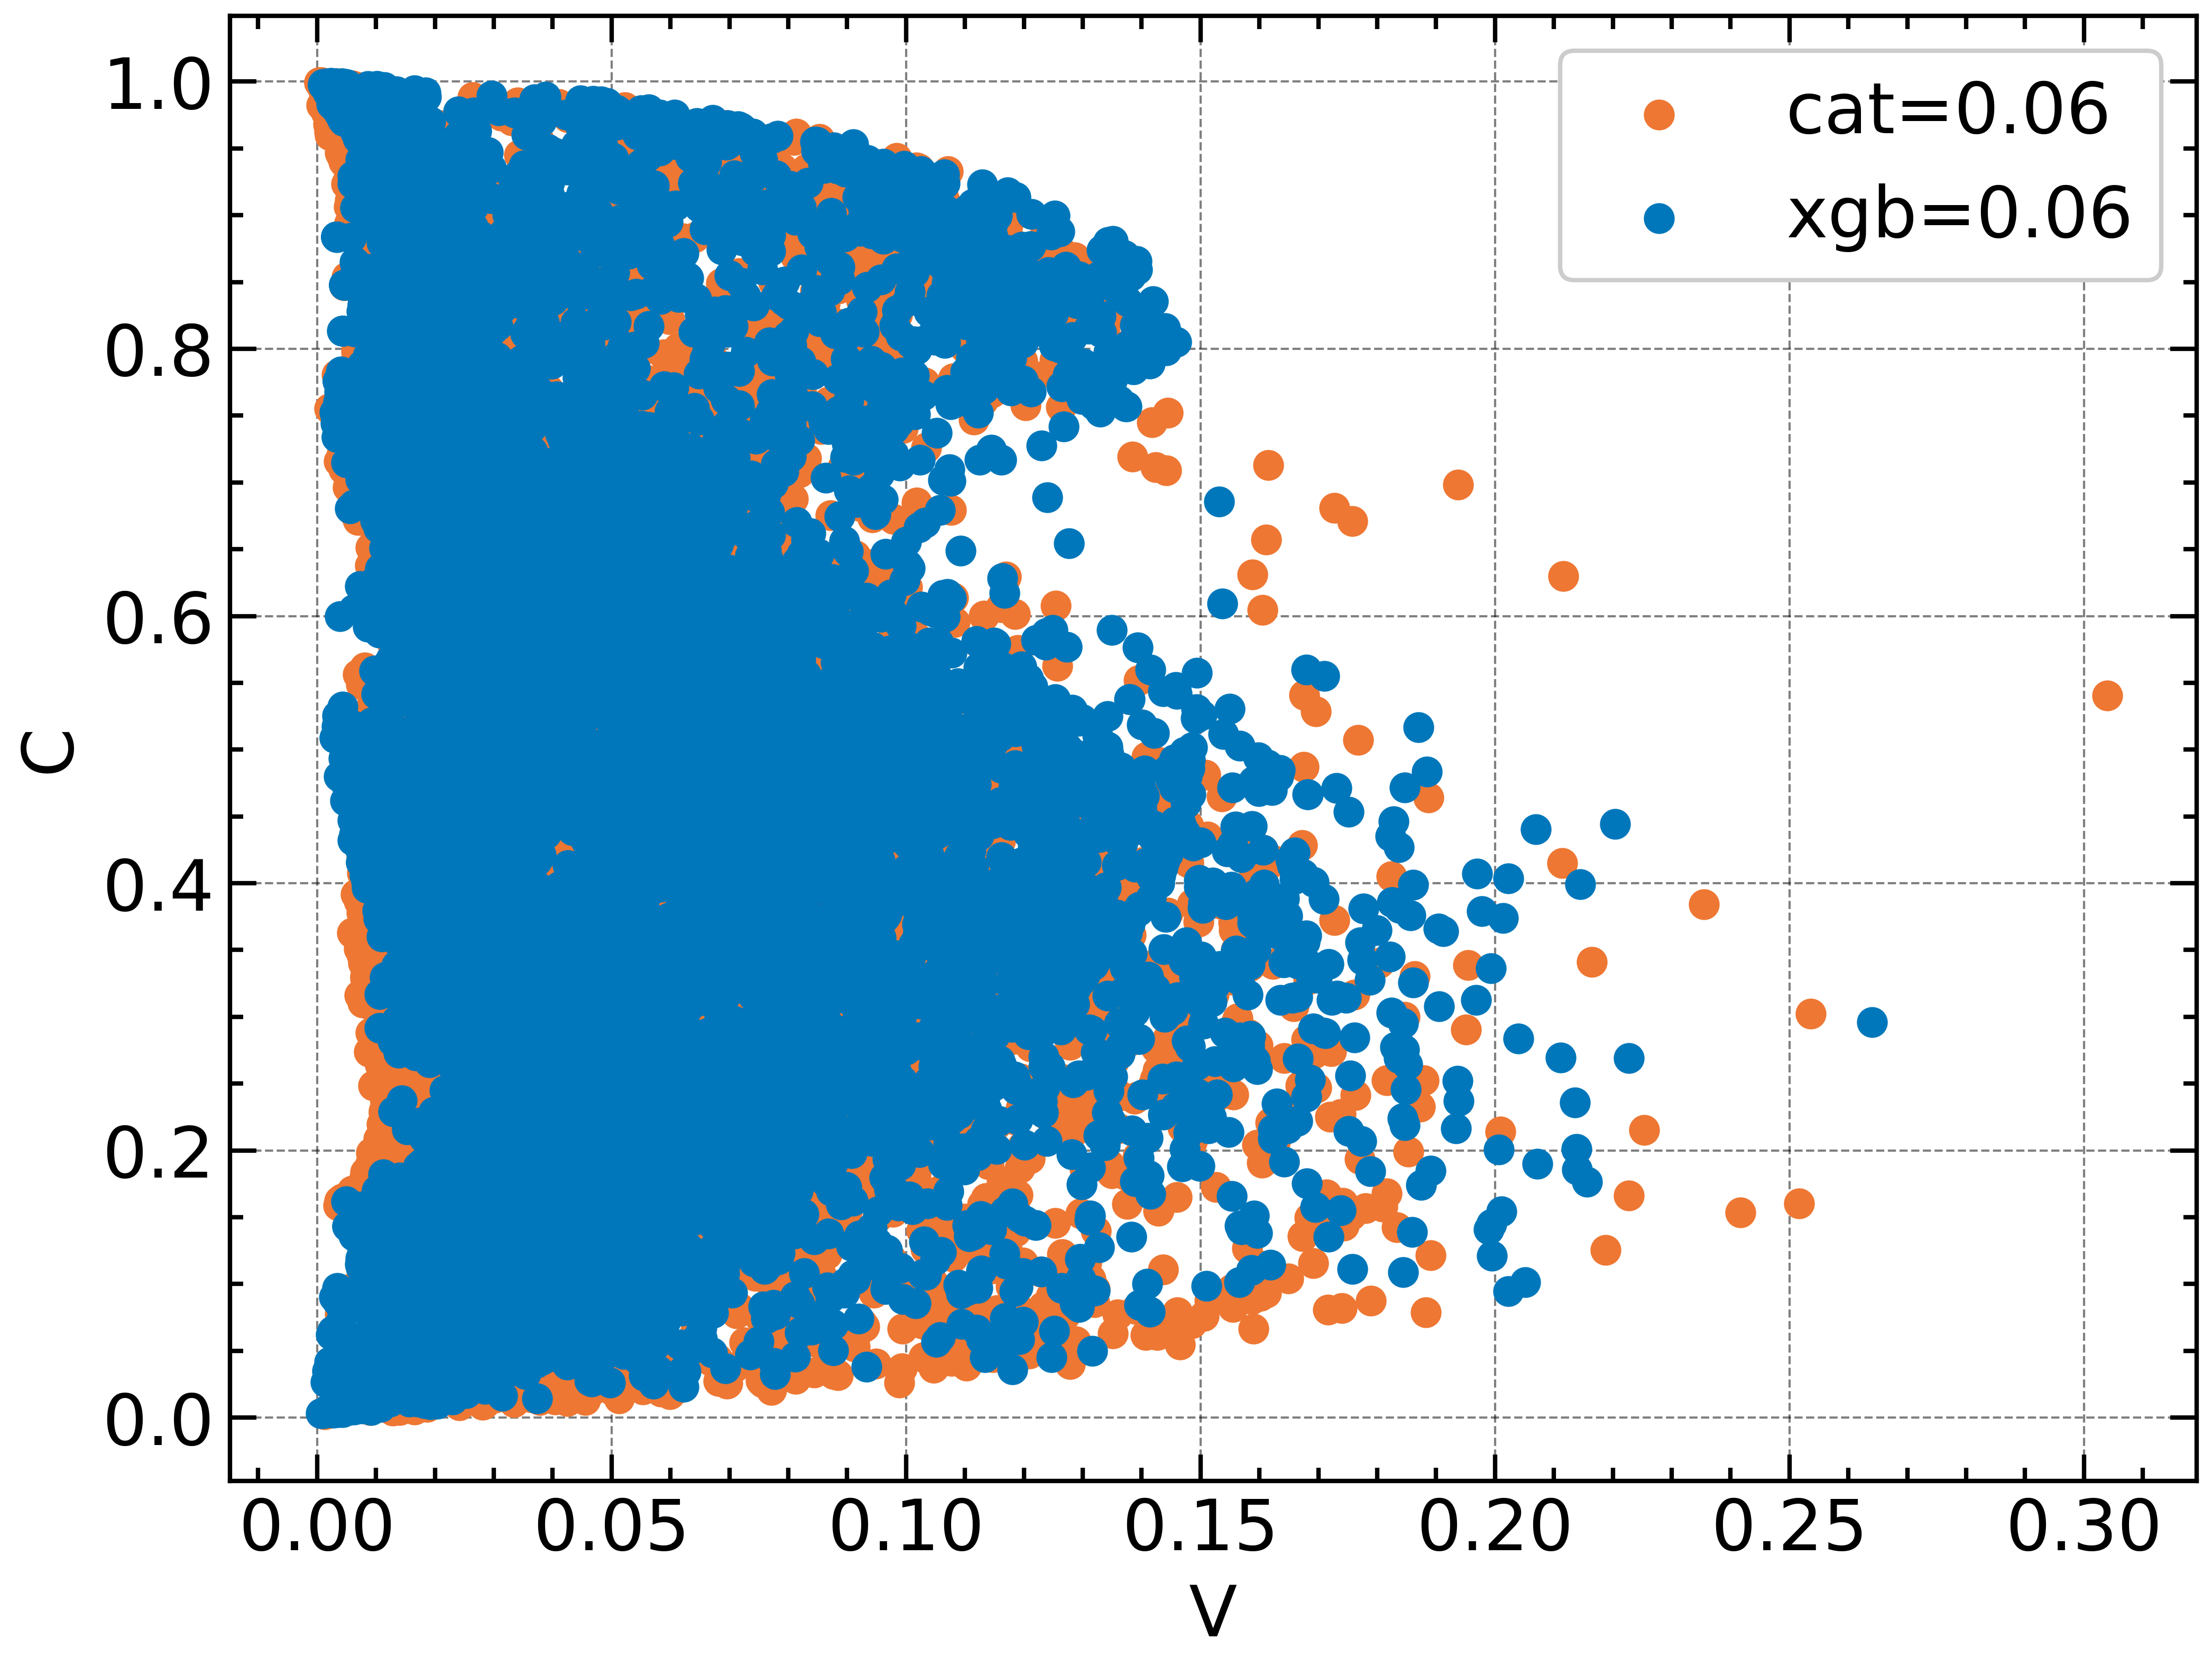

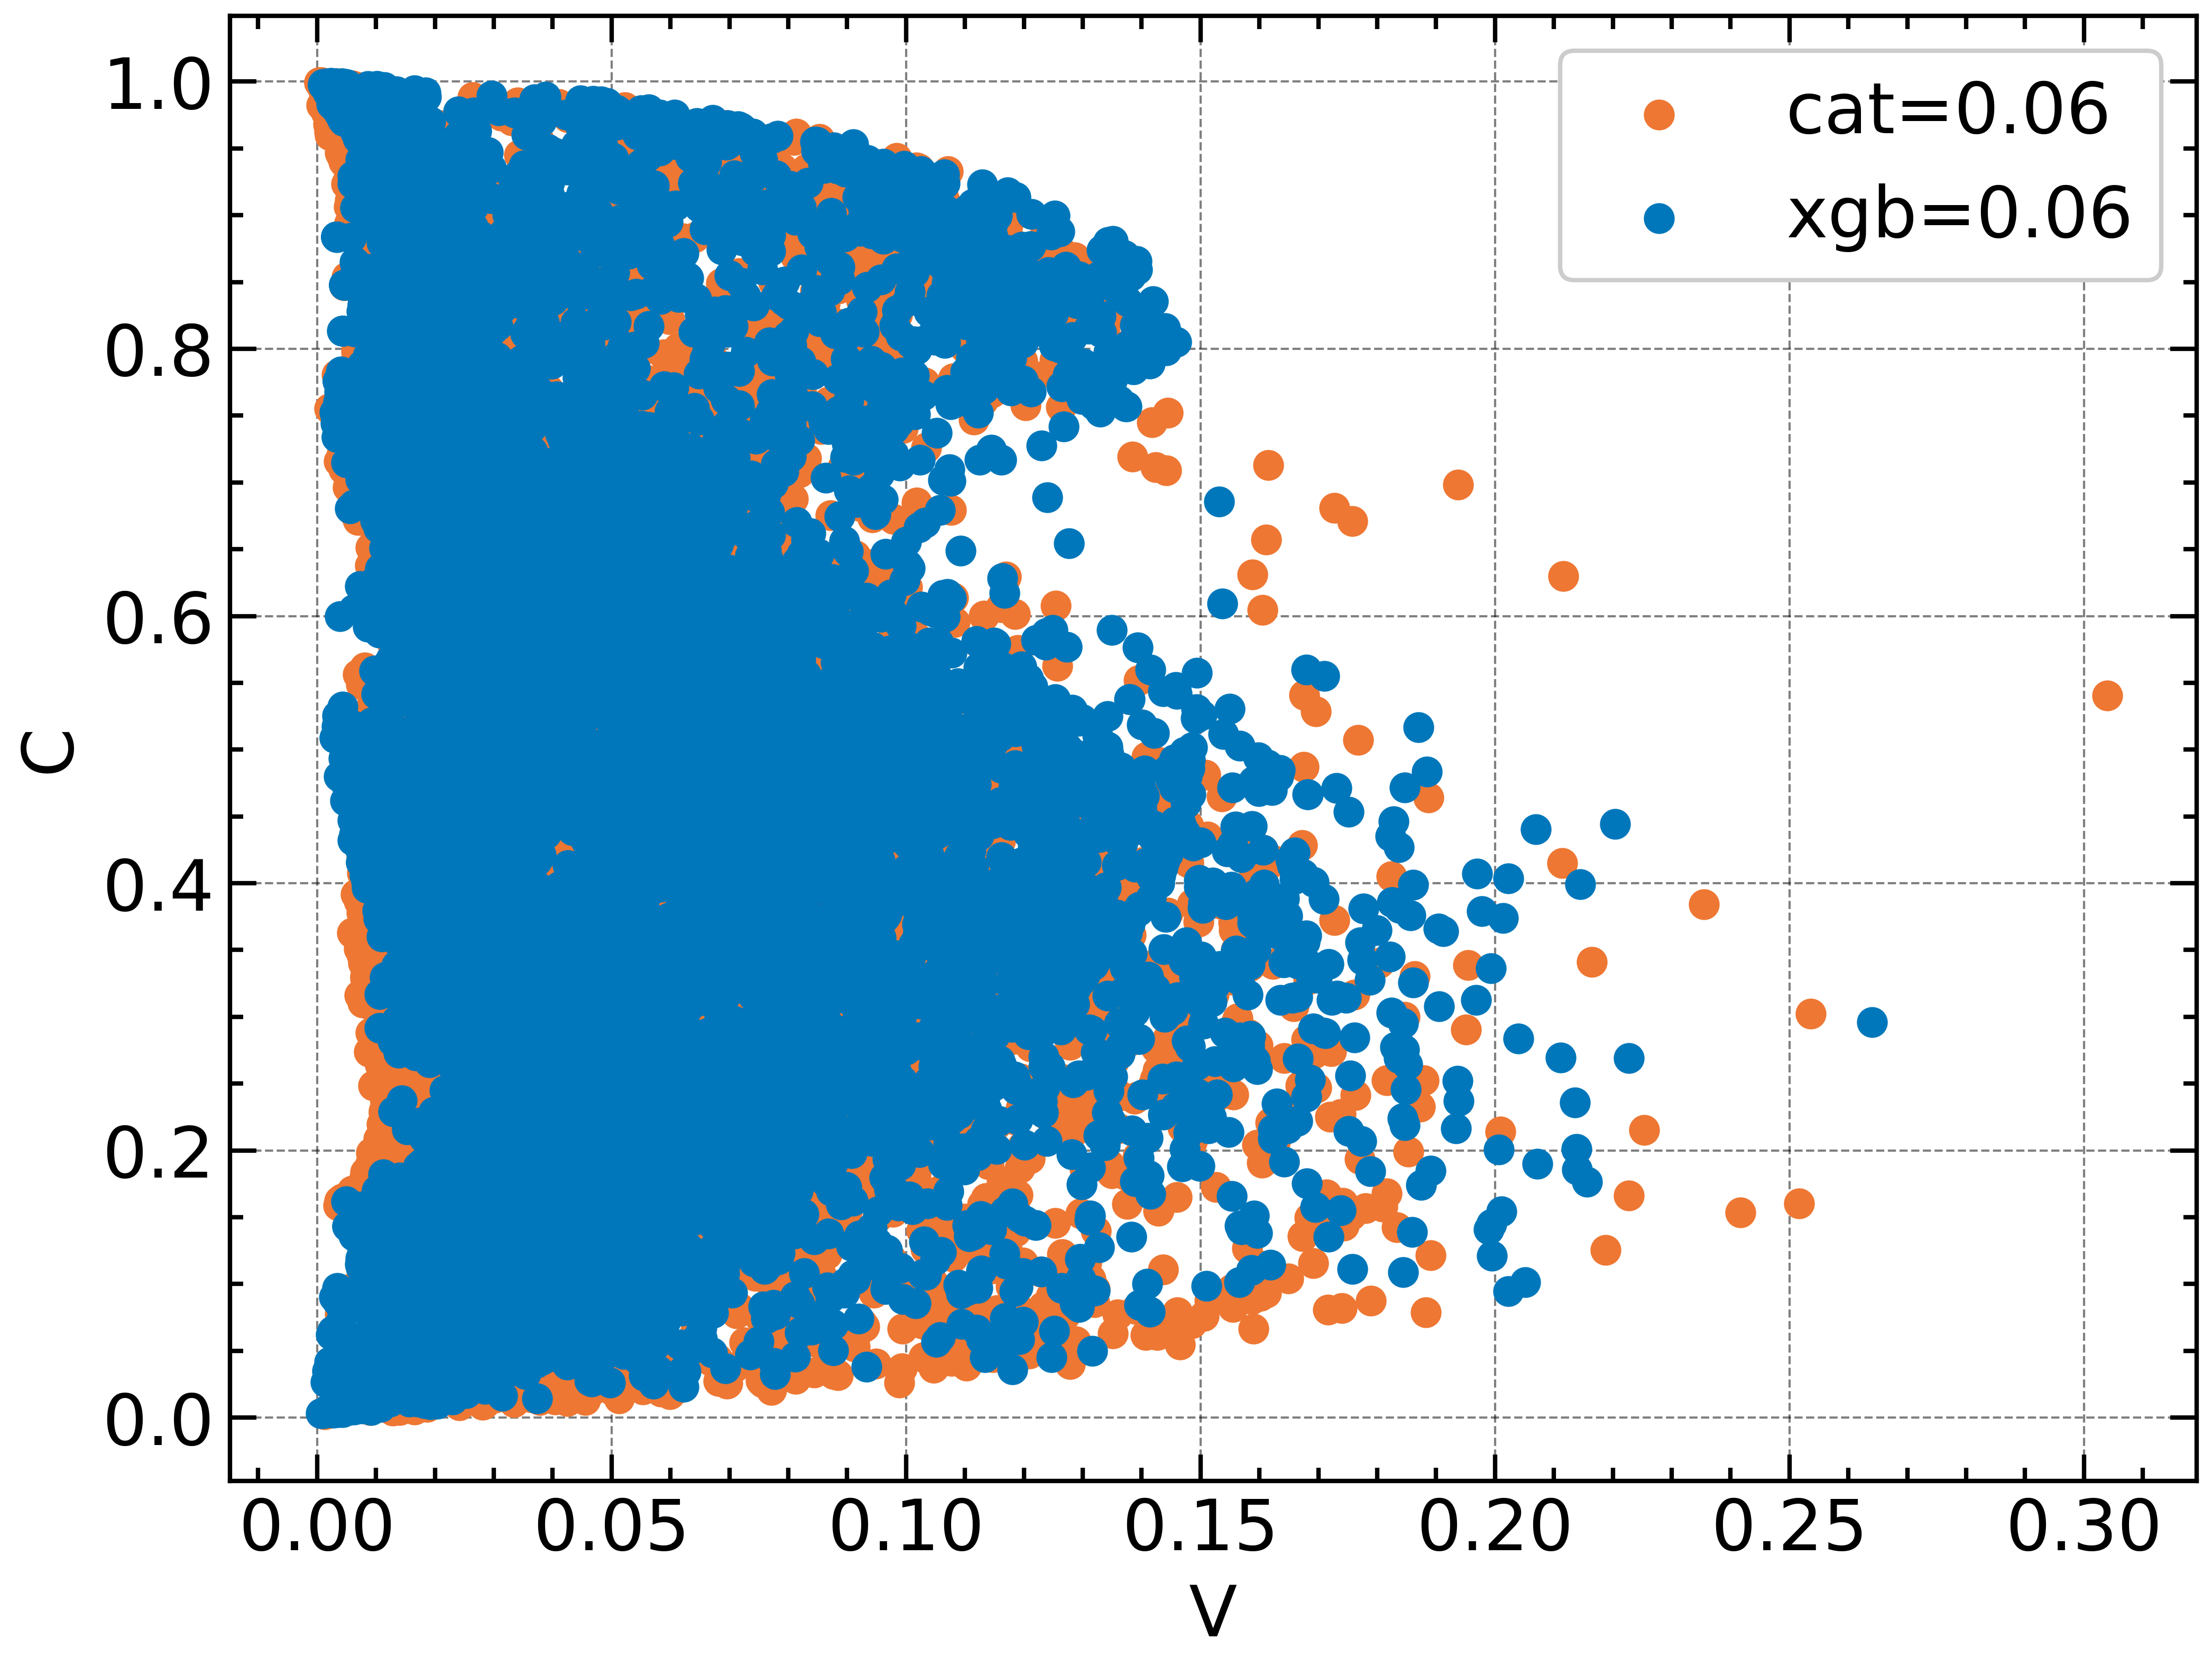

bike
boston


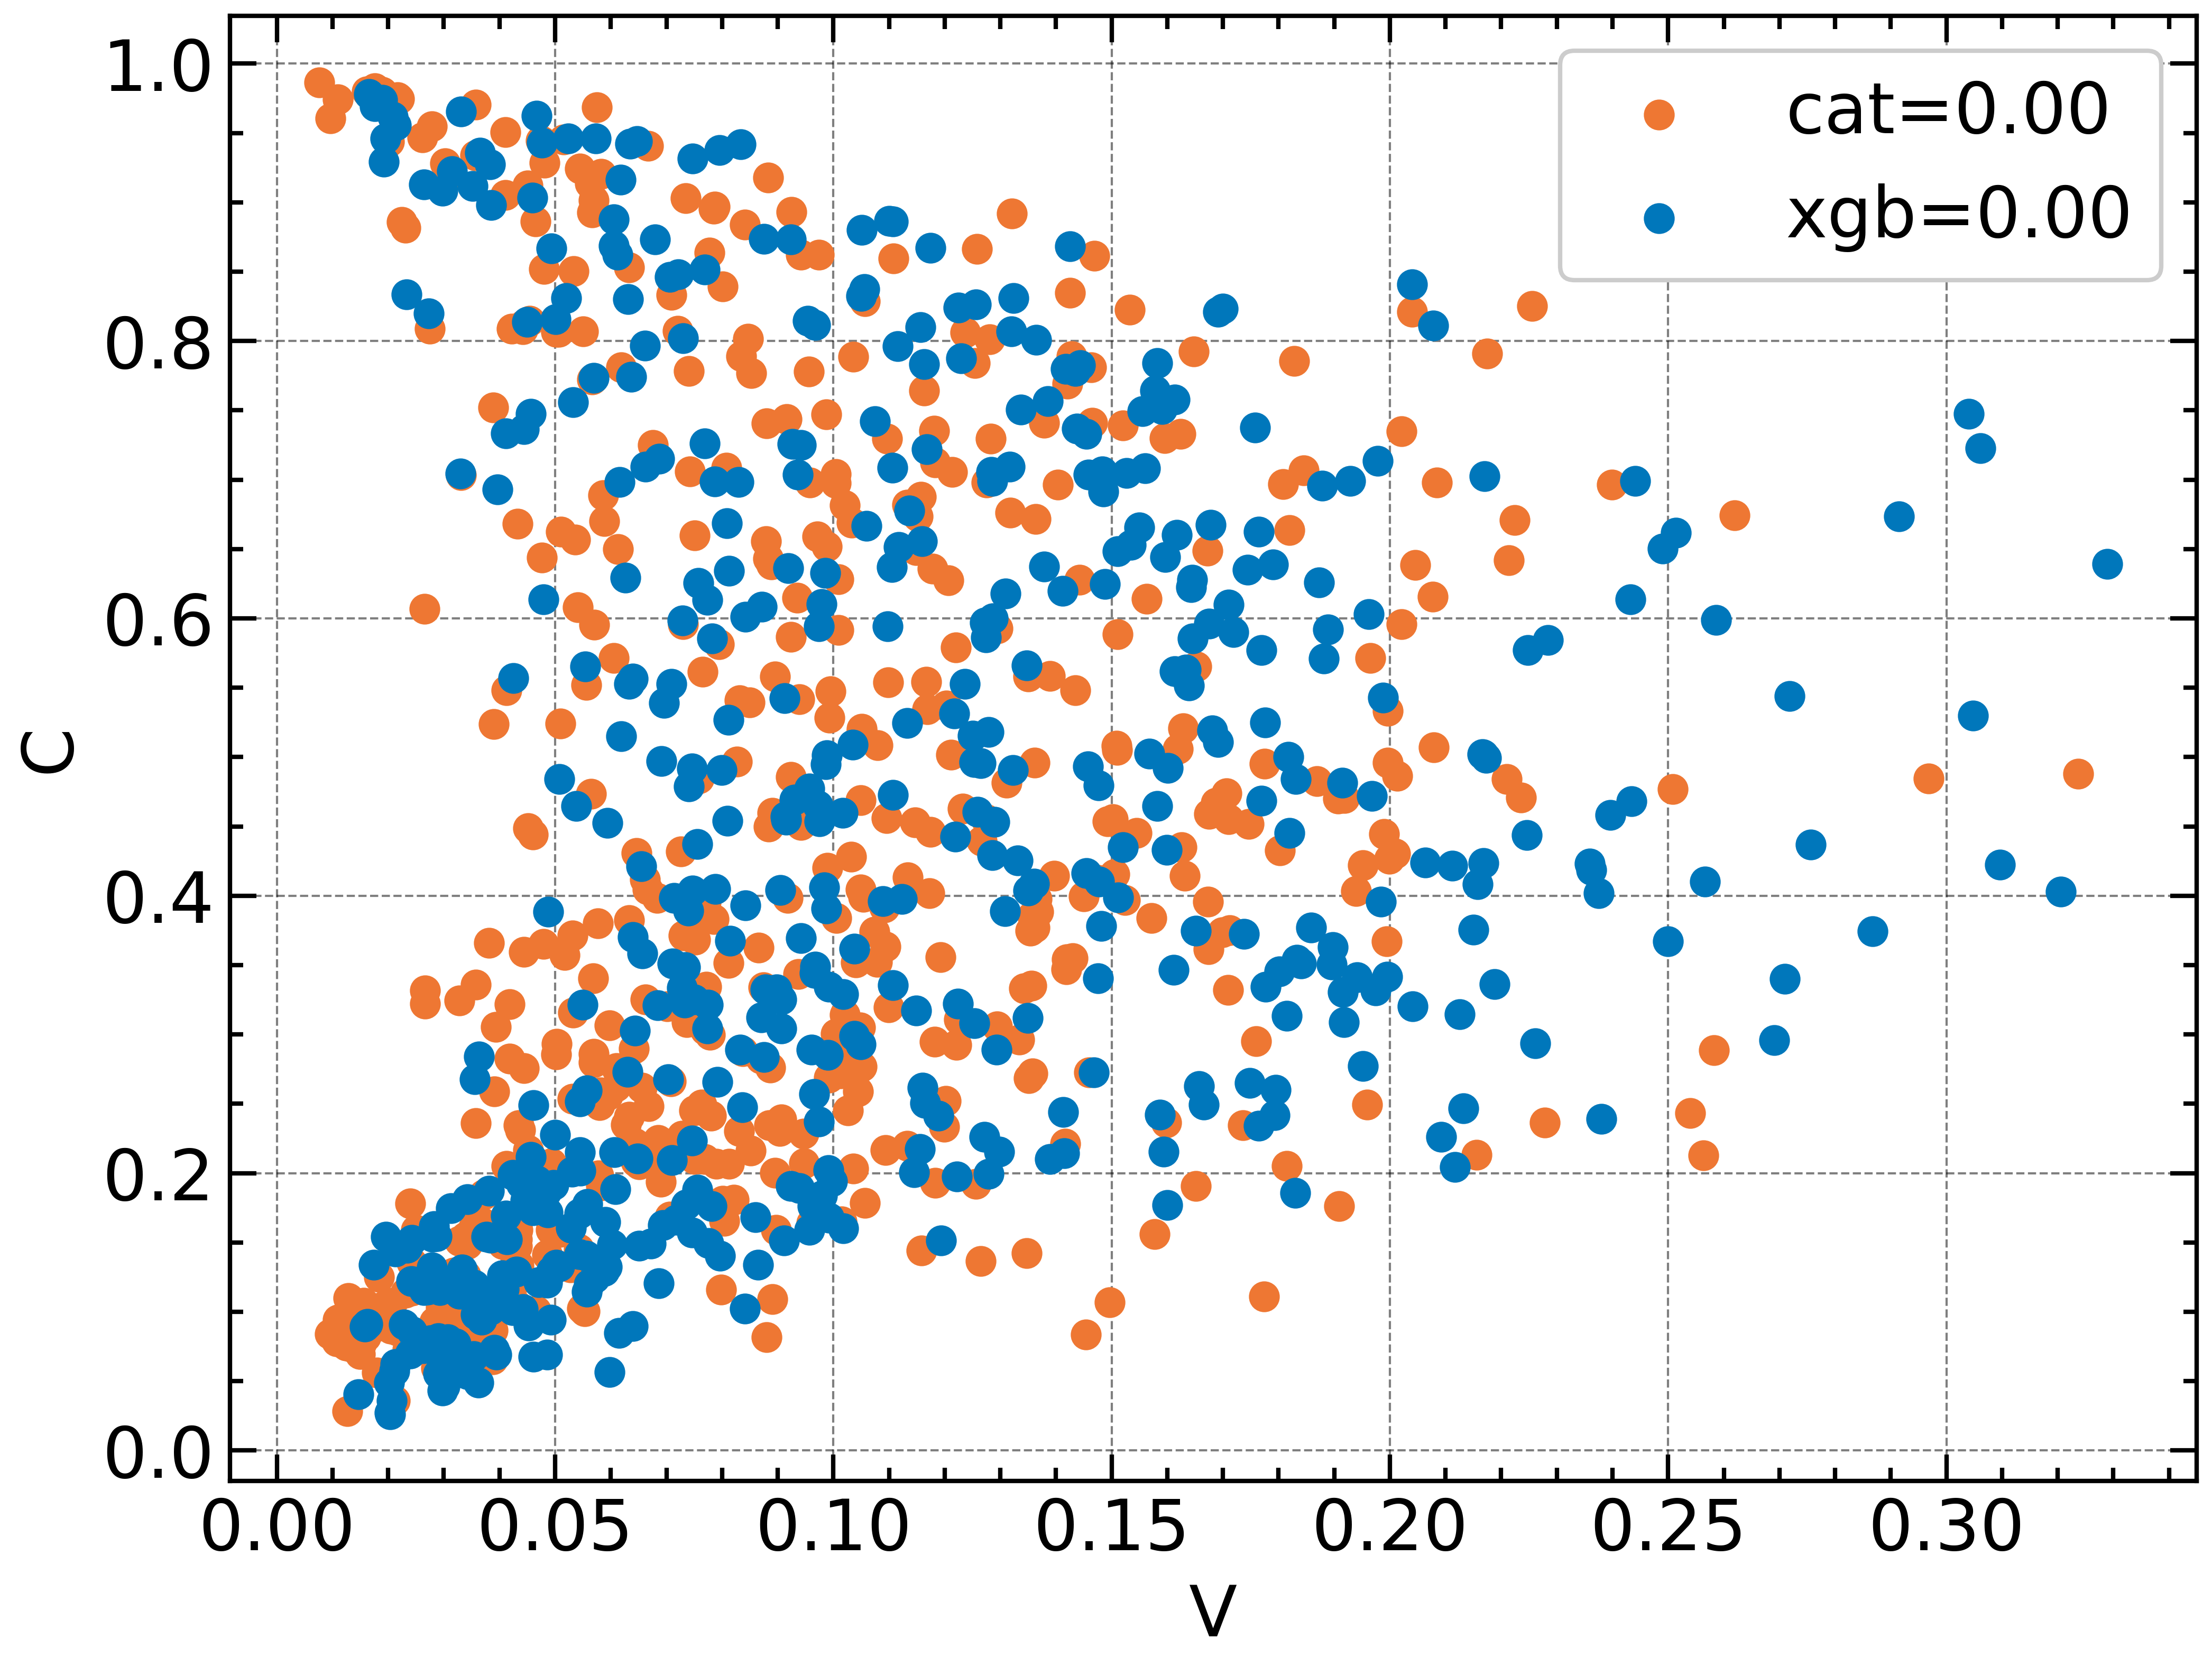

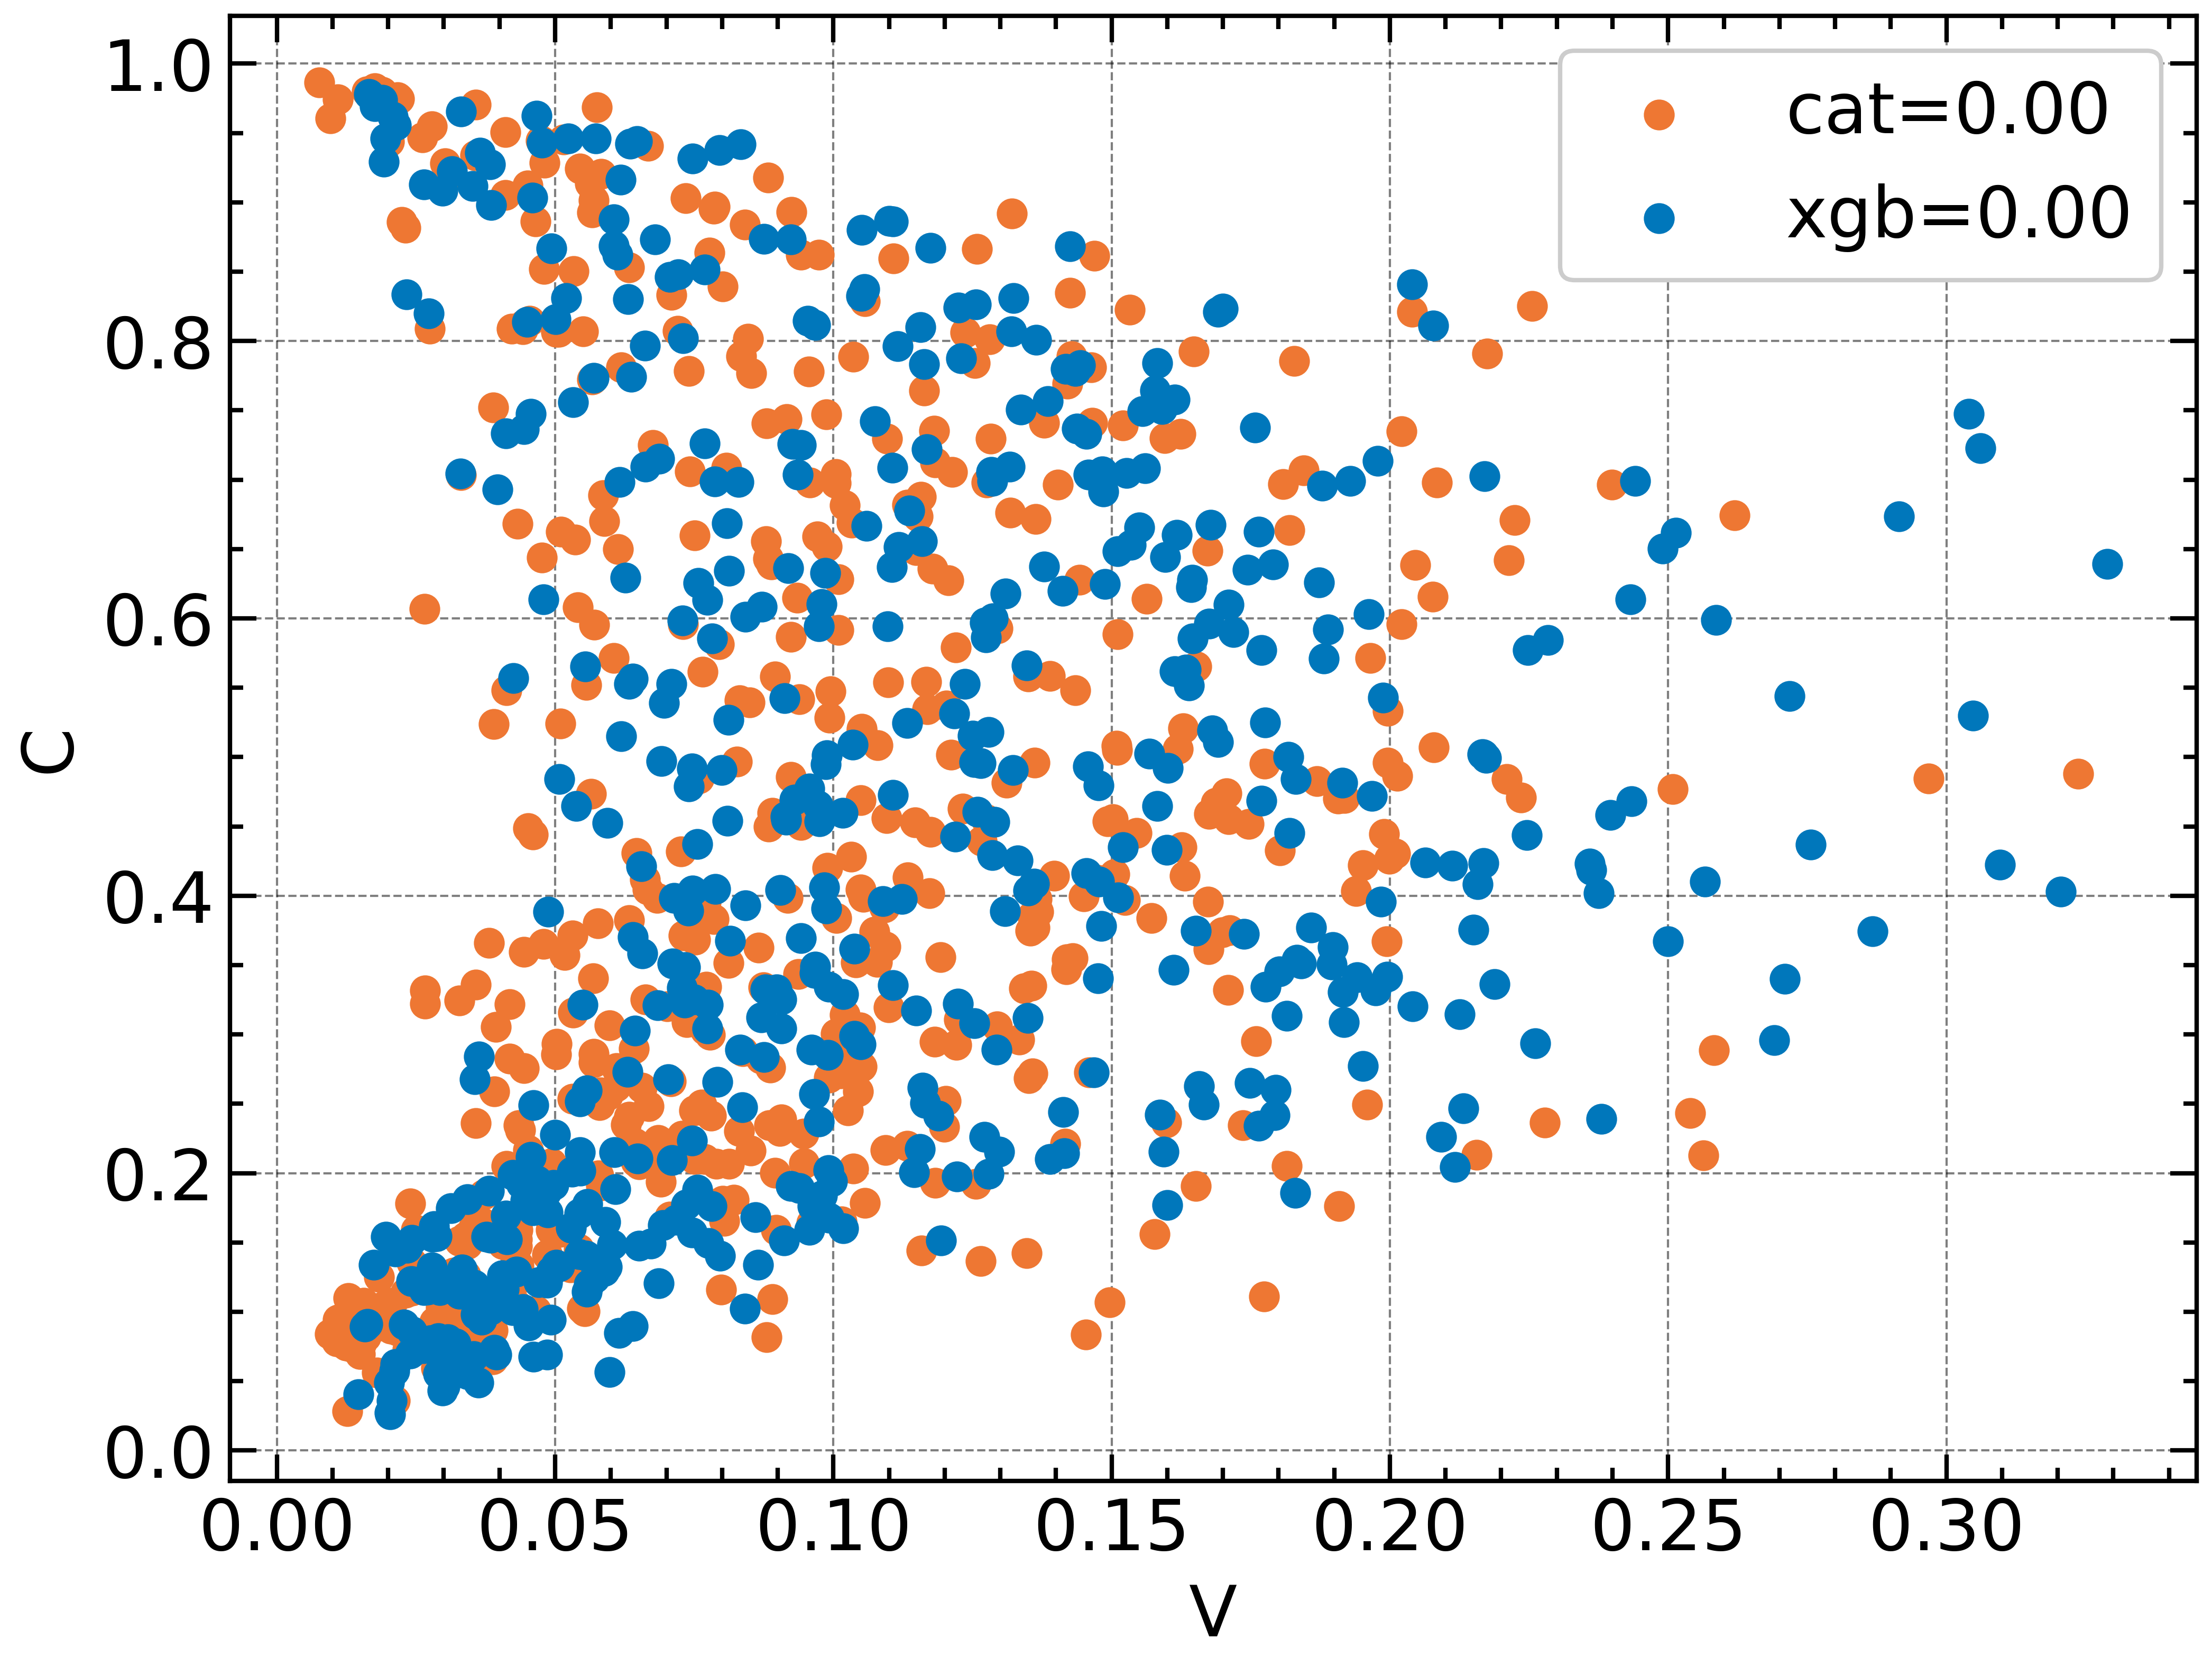

concrete


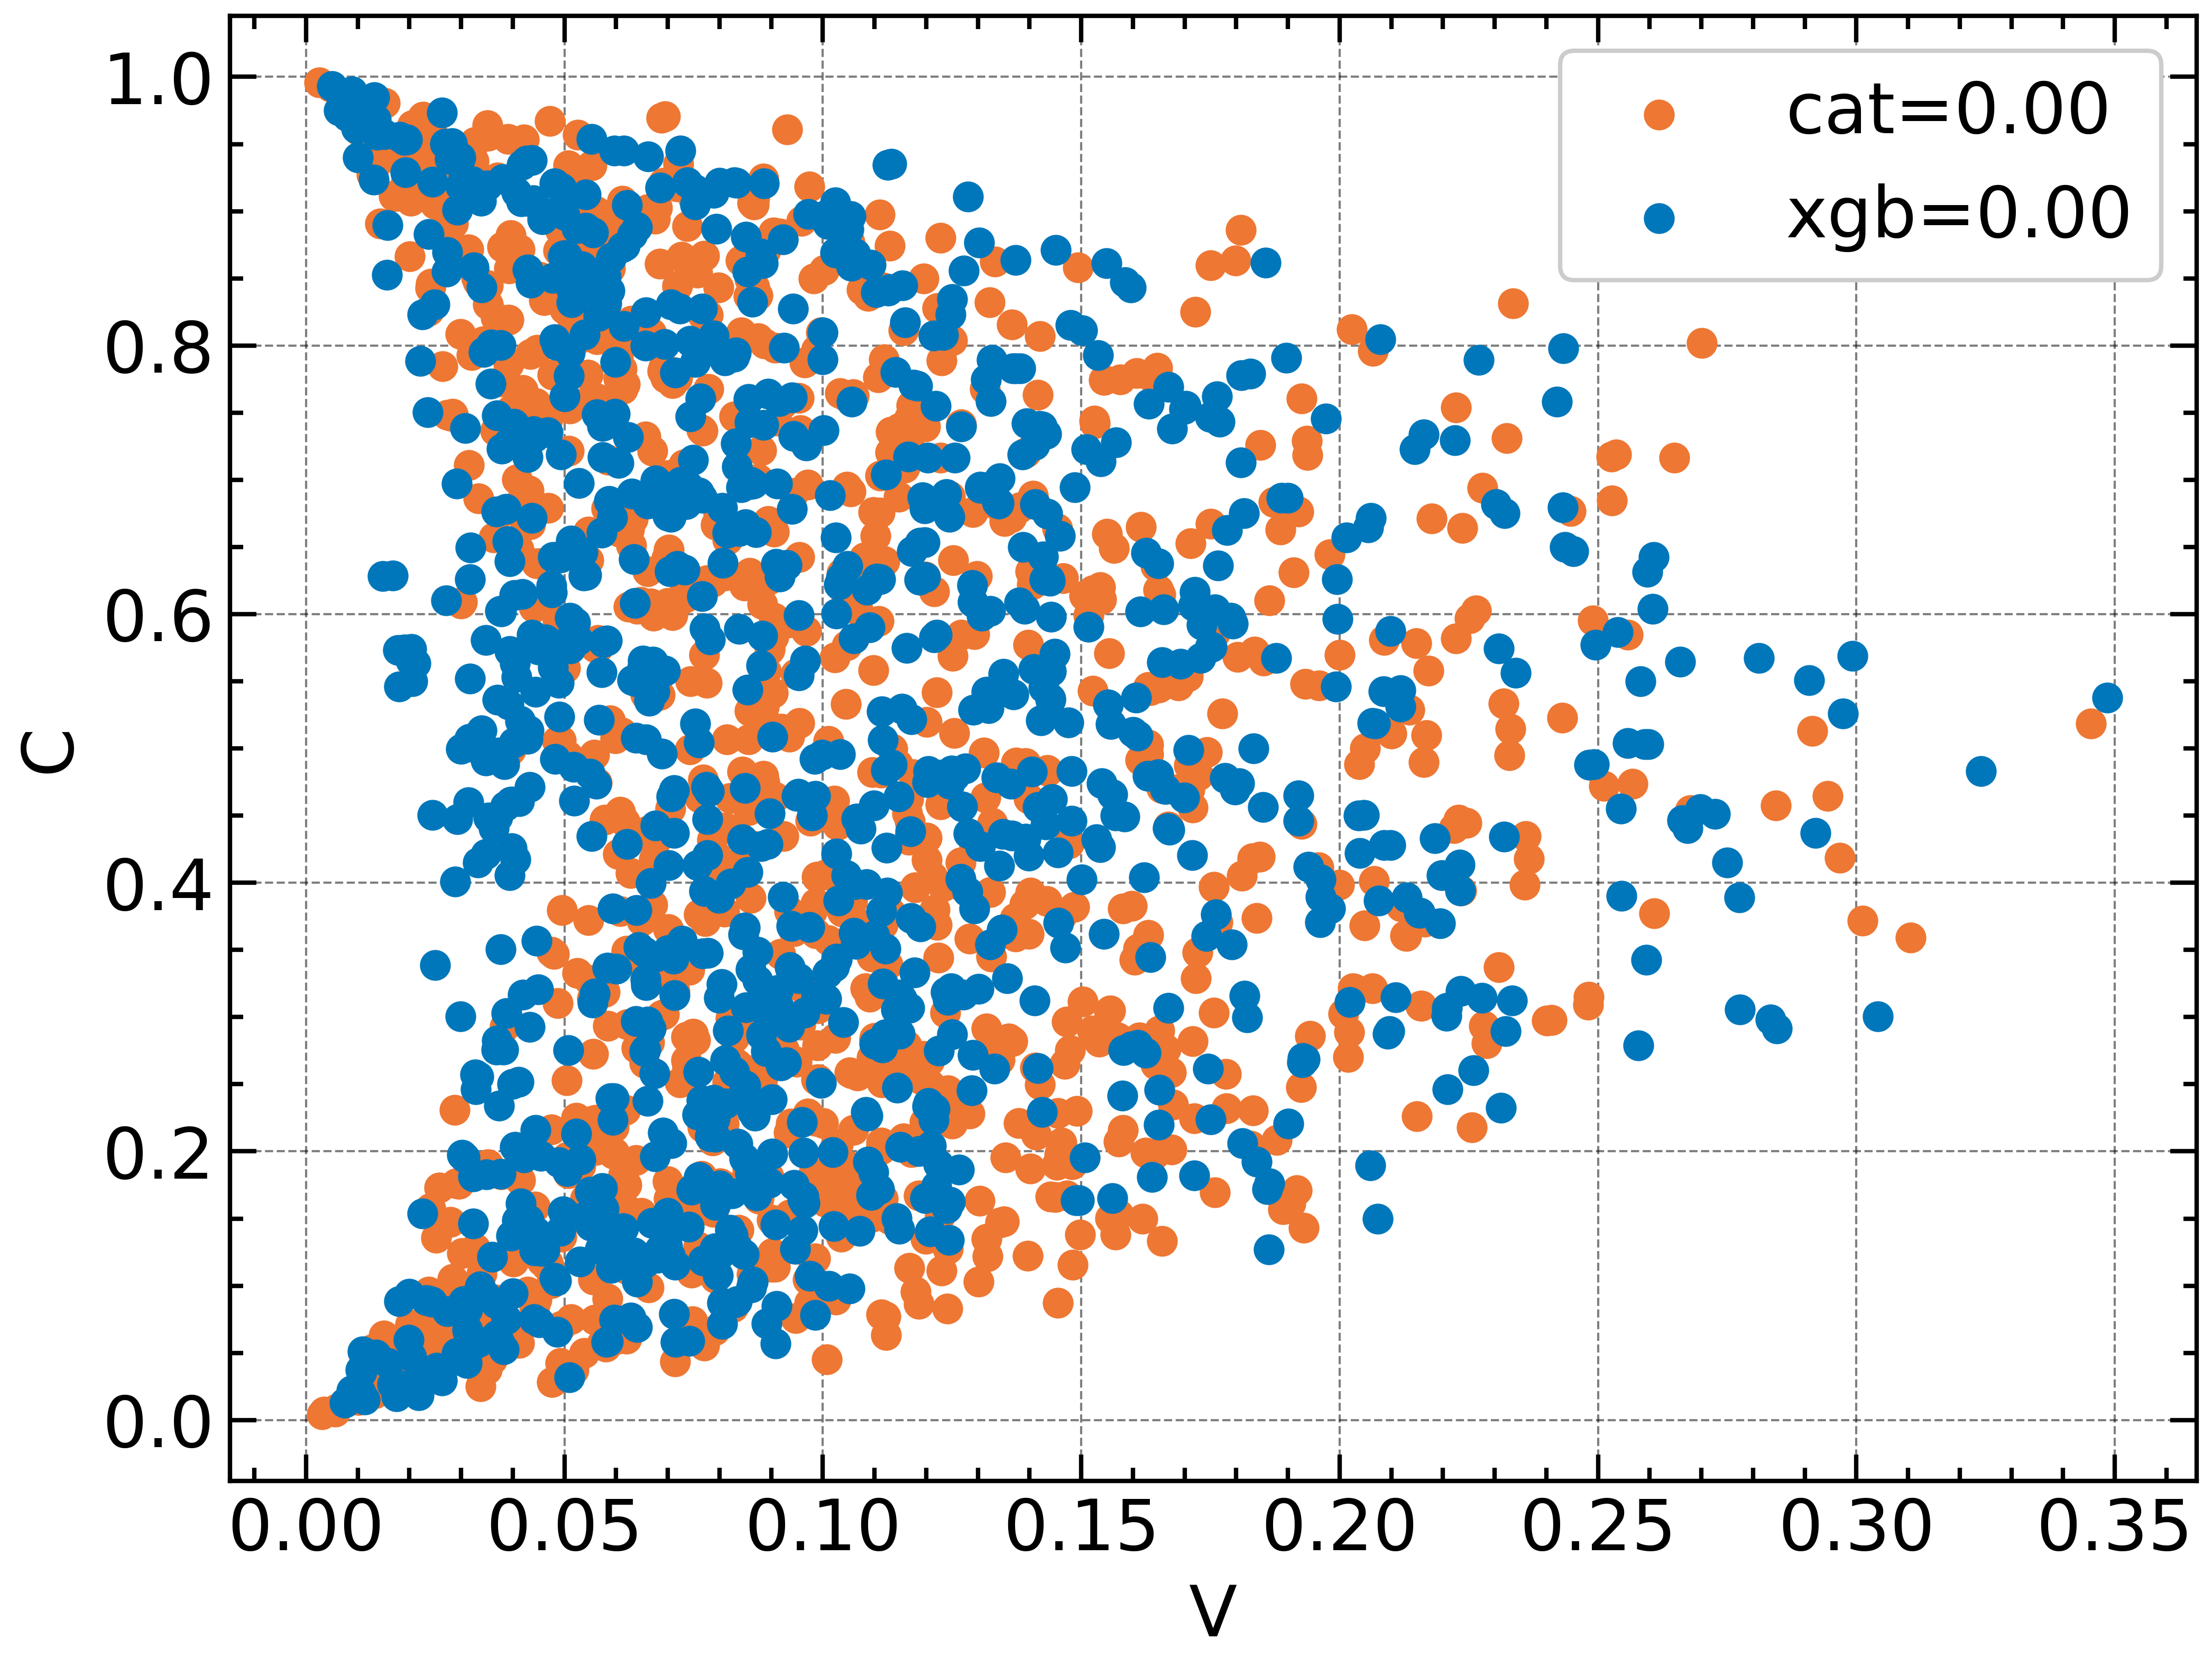

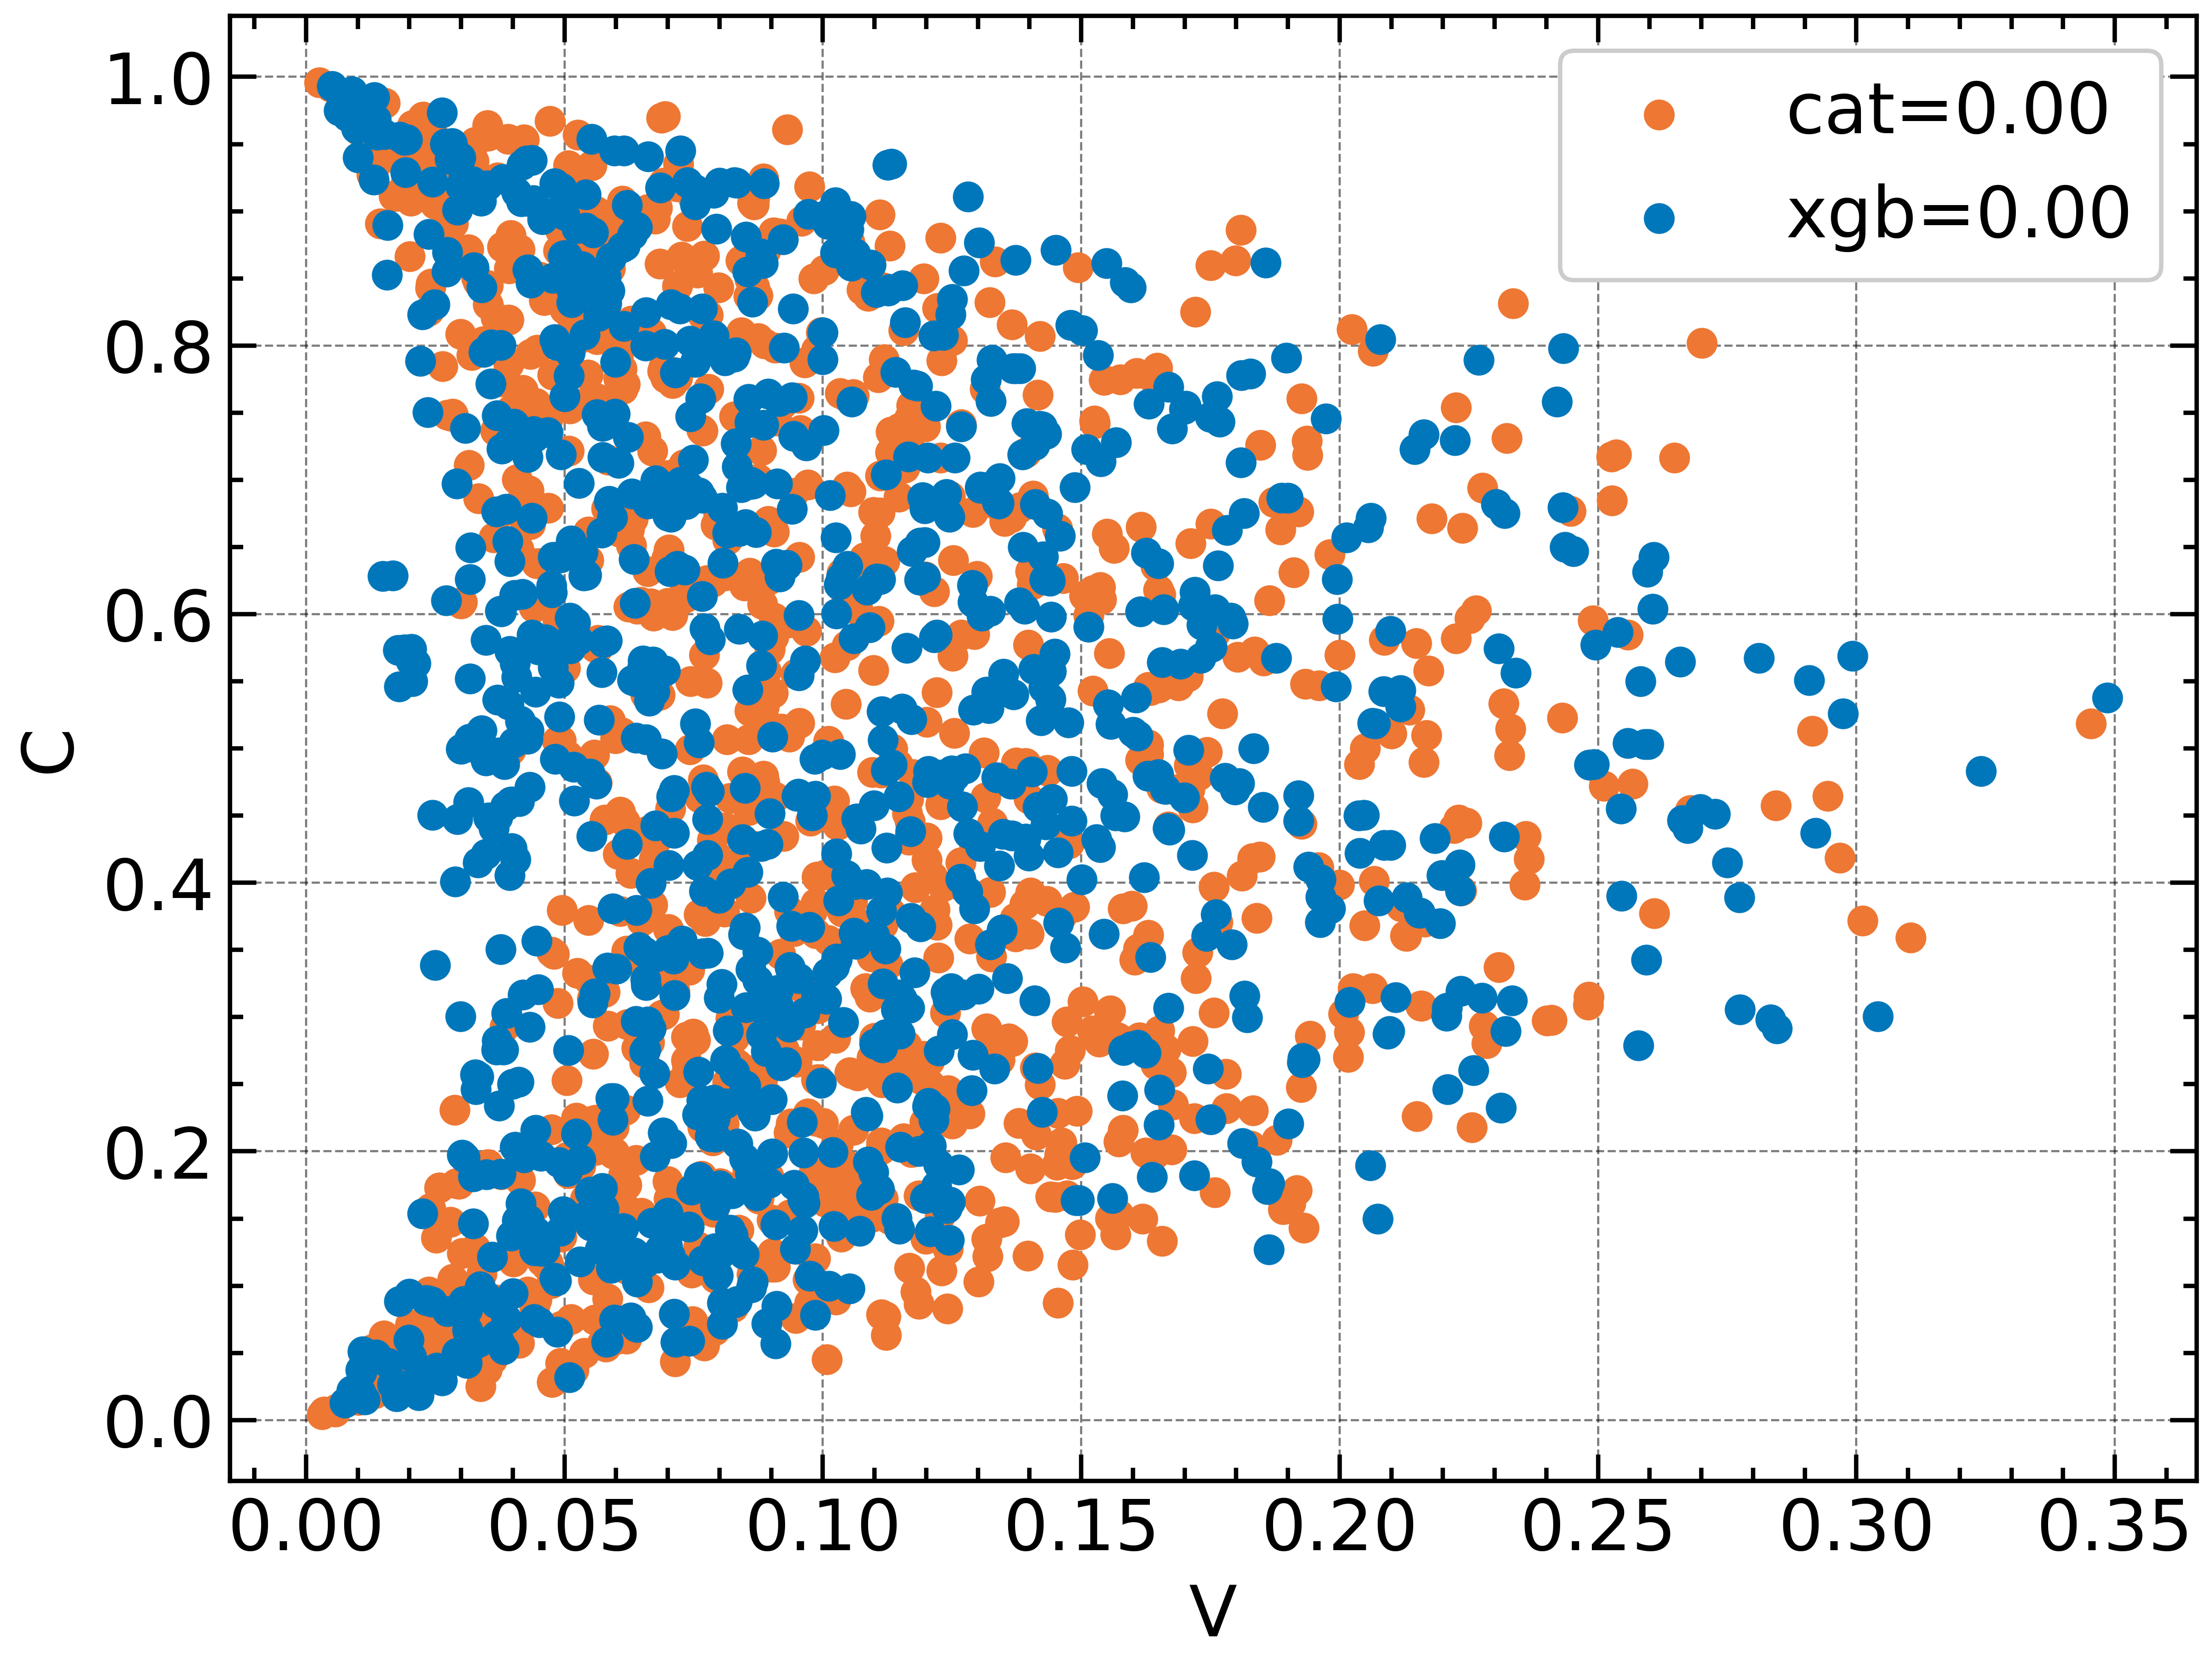

star
protein


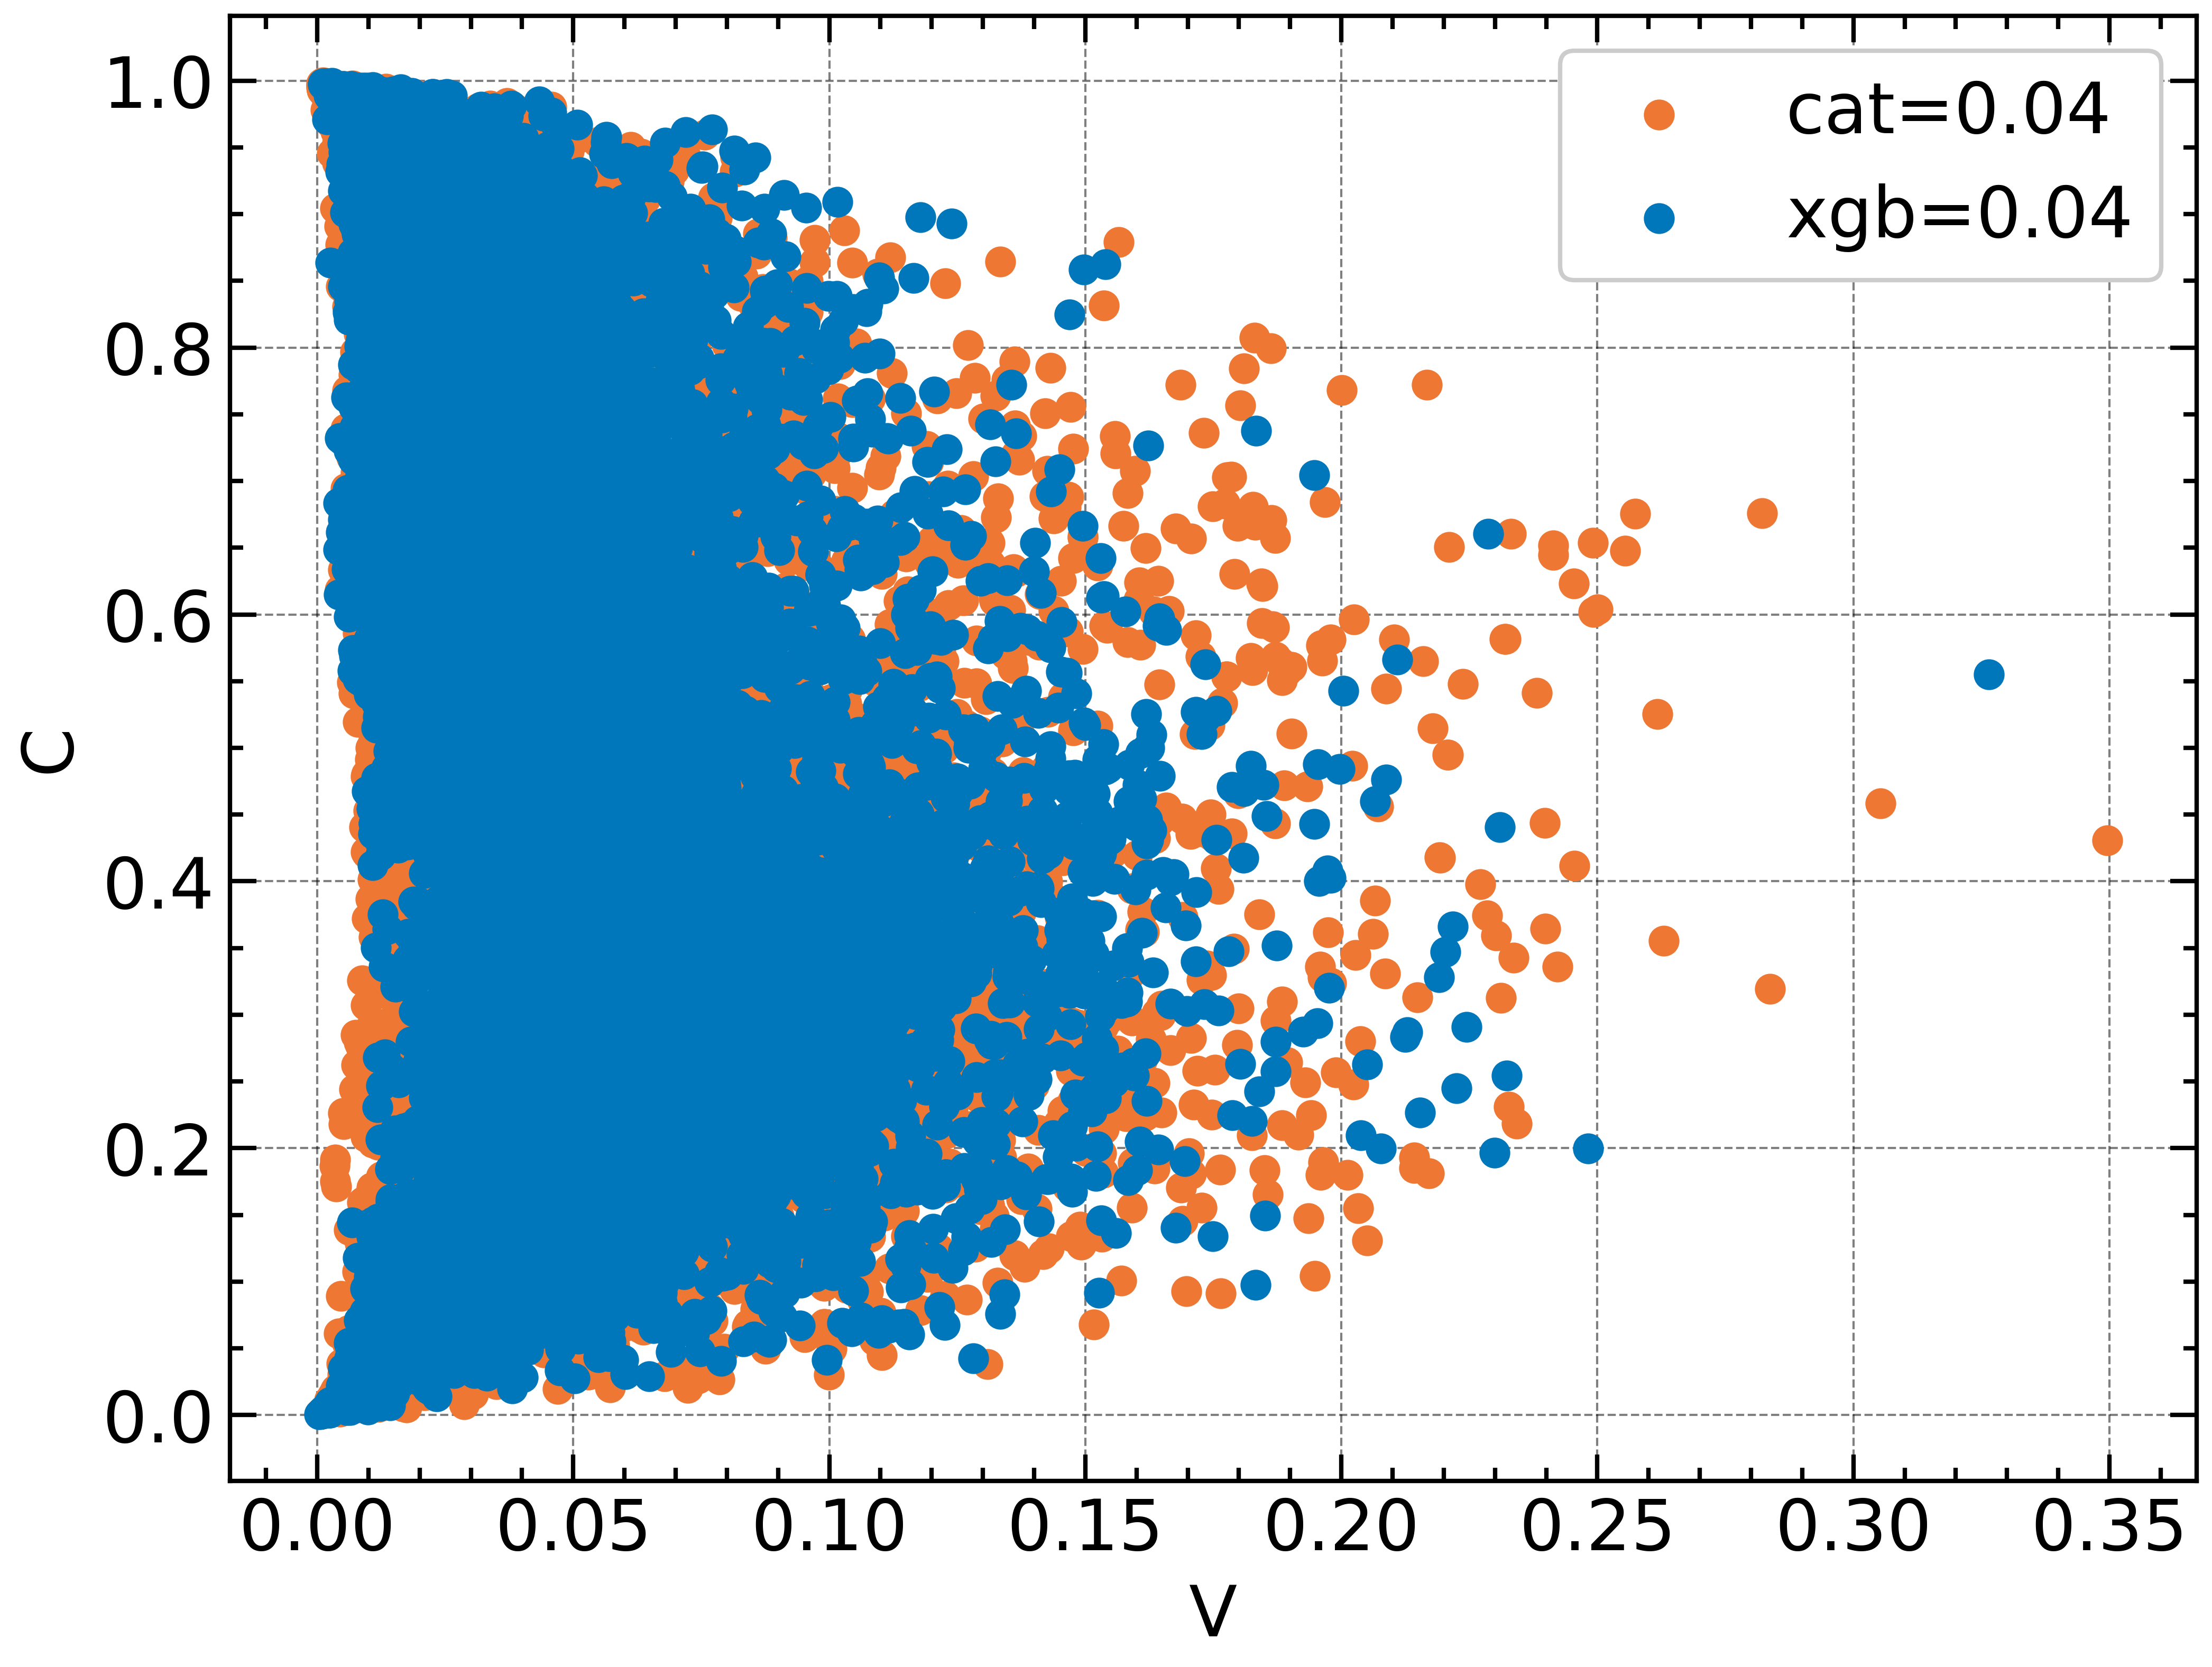

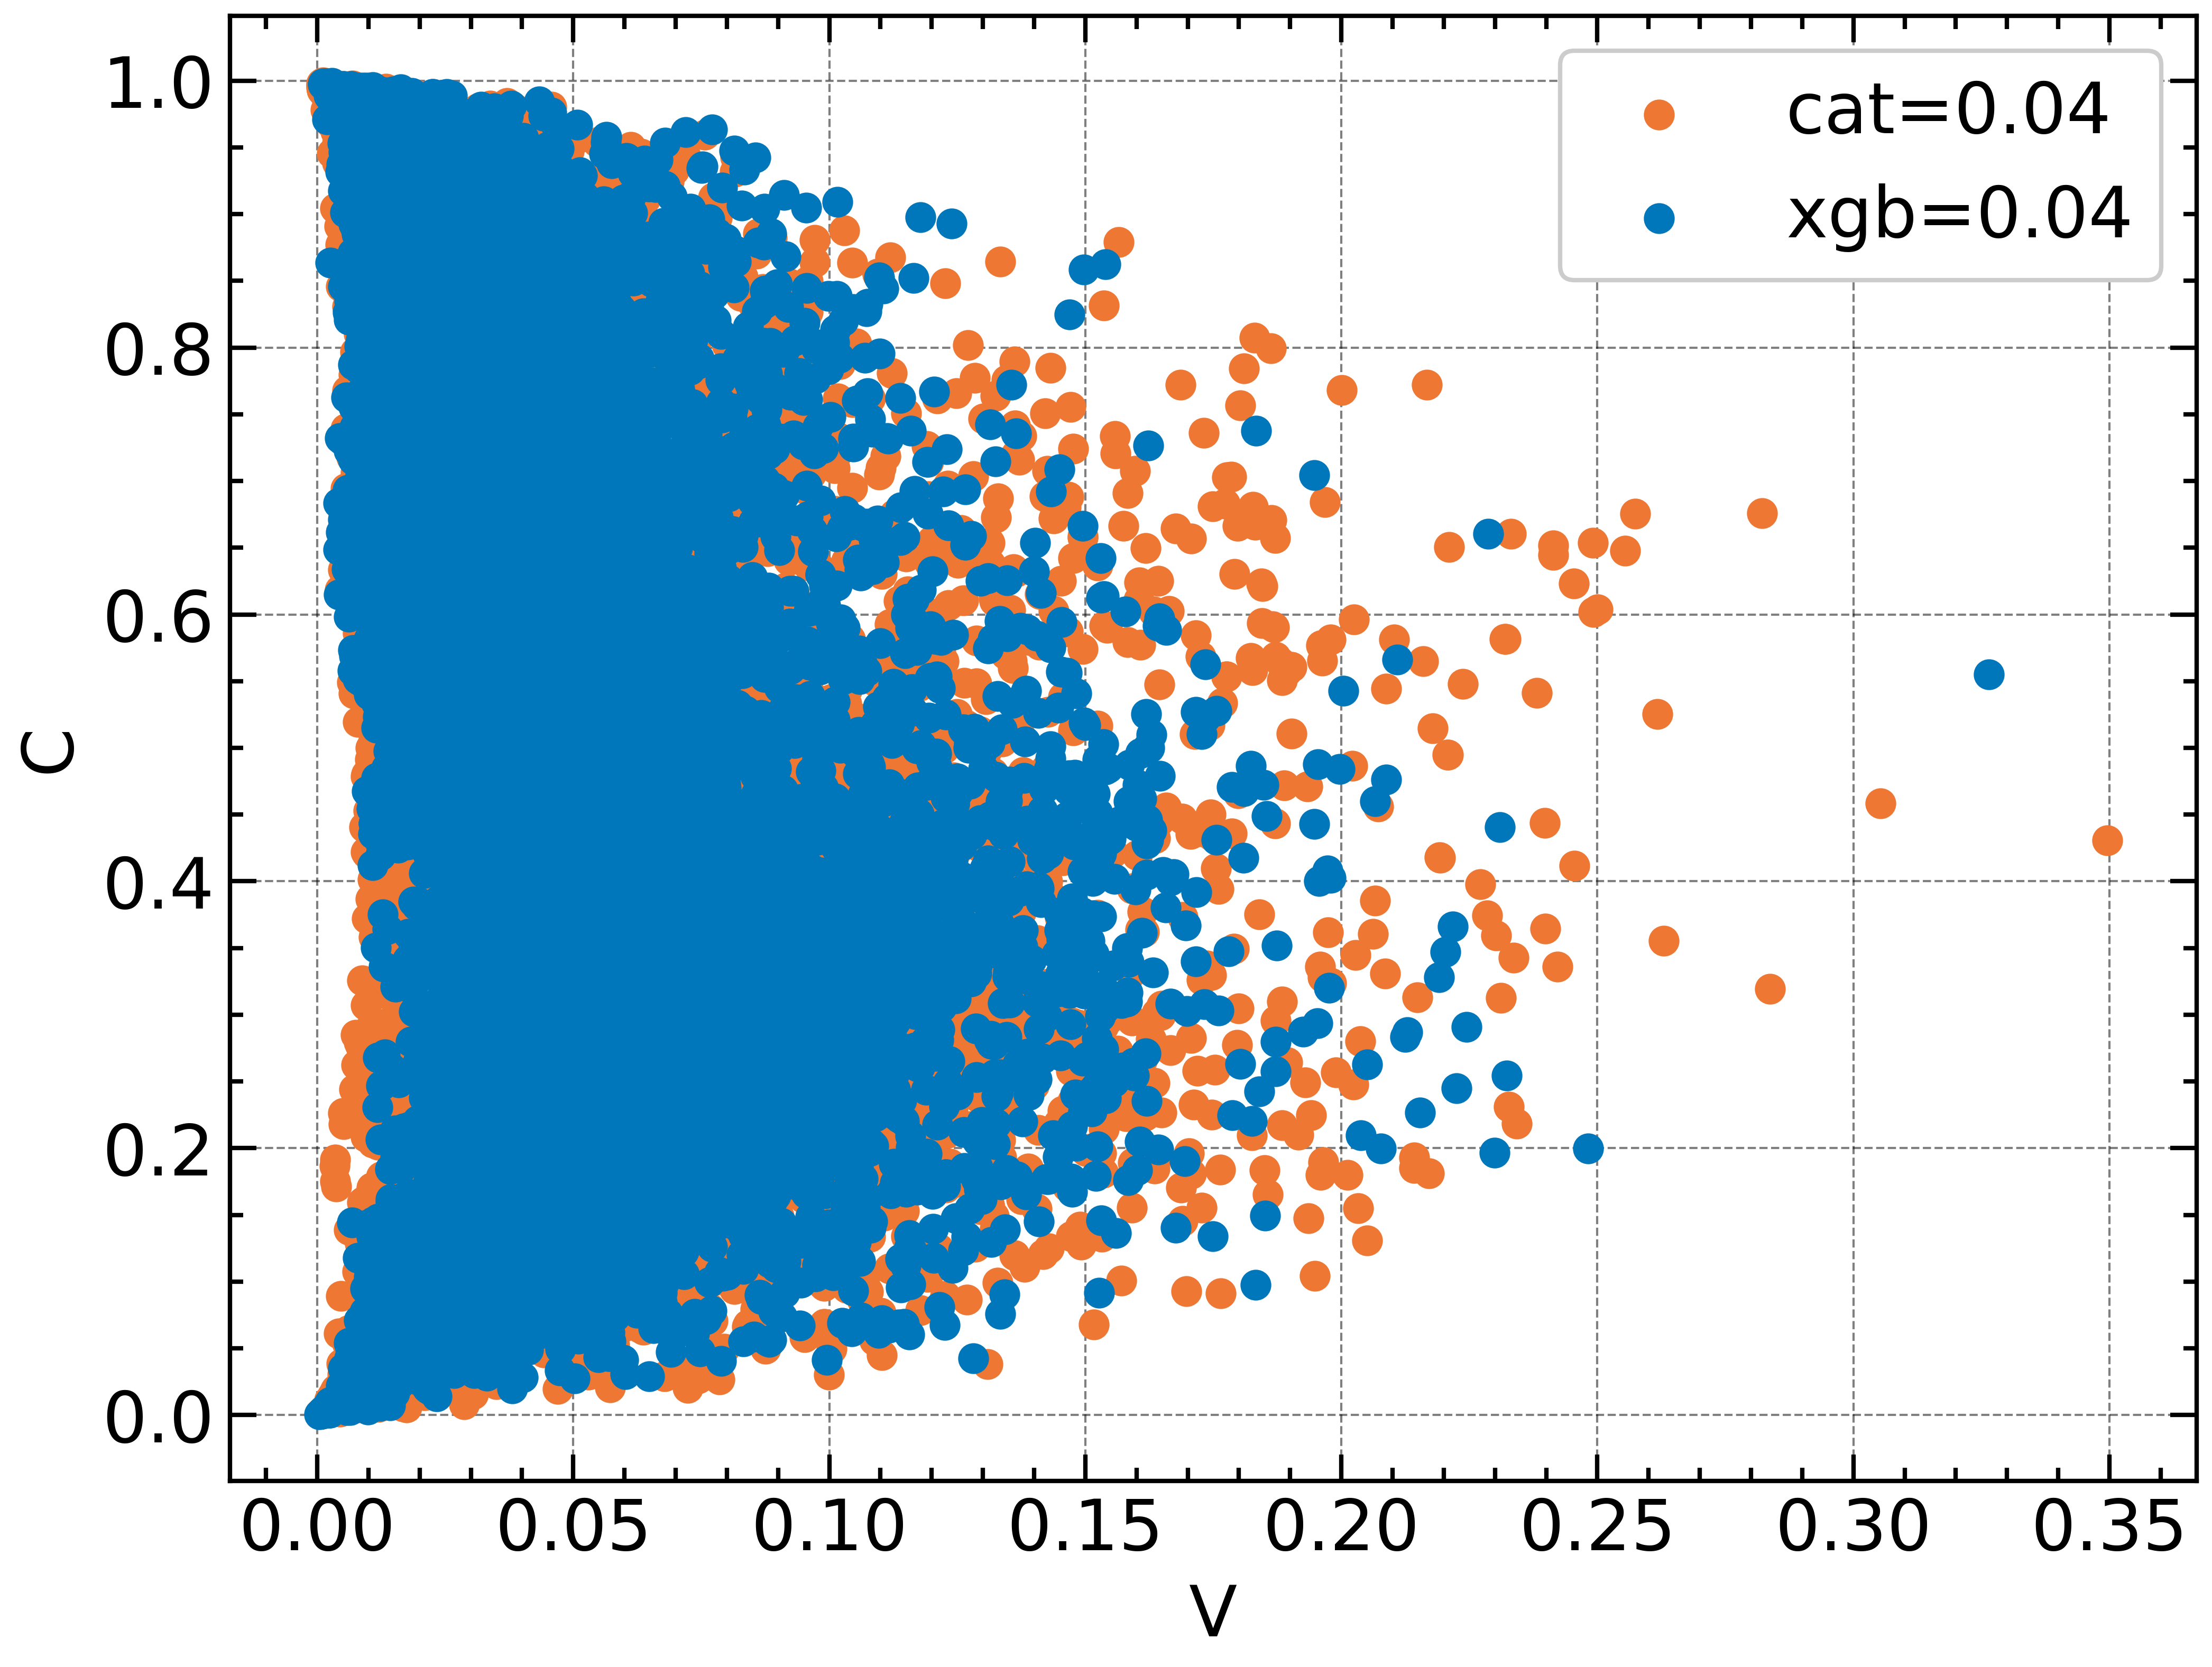

bio


In [12]:
from scipy.stats import spearmanr
for dataset in dataset_lists:

    plt.figure()
    results = {}

    models = [
        CatBoostRegressor(n_estimators=nest + 10, random_state=seed),
        xgb.XGBRegressor(n_estimators=nest, random_state=seed),
    ]
    modelnames = ["cat", "xgb"]

    for idx, learner in enumerate(models):
        scores = [
            final_results[dataset][model]["pvals"]
            for model in list(final_results[dataset].keys())
        ]

        corr = spearmanr(
            np.mean(scores[0], axis=-1), np.mean(scores[1], axis=-1)
        )[0]

        final_corr[dataset] = corr

        plot(final_results, dataset)

In [ ]:
final_corr

{'prostate': 0.9776443302324432,
 'bike': 0.725123700423237,
 'boston': 0.754485826766366,
 'concrete': 0.7447517239843766,
 'star': 0.9576366001757294,
 'protein': 0.925547091219471,
 'bio': 0.9255471176074712}